
# 1) Intro — Multi-Agent Nutritionist (Two Models)

This workshop uses **two cooperating agents**:

- **Consultant (Medical Expert) — `Qwen/Qwen3-30B-A3B-Instruct-2507-FP8`**  
  Acts as the *brain* for our medical expert agent. It has access to a **local OpenNutrition DB** (ingredient/nutrition data + potential health warnings).  
  It **assesses the ingredients** of a provided food item and returns an expert analysis plus **healthier alternatives**.

- **Orchestrator (Vision + Retrieval) — `Qwen/Qwen3-VL-30B-A3B-Instruct-FP8`**  
  Accepts **images (labels/barcodes)** or **text**. Uses **OpenFoodFacts (OFF) API** tools to gather ingredients.  
  If OFF fails, it uses **EXA via MCP** as a fallback web search.  
  Finally, it **consults the expert agent** and produces a full analysis and suggested **healthier alternatives**.
  
![Architecture Overview](multi-agent-arch.jpg)


# 2) Flow, Goals, and Agenda

## Flow (High Level)
1. Orchestrator receives input (image/barcode/text) for a snack/food.
2. Orchestrator looks up **ingredients** using **OFF API**; if not found, uses **EXA (MCP)**.
3. Orchestrator passes clean ingredients (or product name) to **Consultant**.
4. Consultant evaluates risks, flags concerns, and proposes **healthier alternatives**.
5. Orchestrator returns a concise, user-friendly **verdict + reasons + alternatives**.

## What You Will Build
- A **Vision-capable Orchestrator agent** (Qwen VL) with tools for **OFF** and **EXA (MCP)**.
- A **Consultant agent** (Qwen 30B text) backed by a **local OpenNutrition DB** toolset.
- The **glue** that lets the Orchestrator consult the Consultant automatically.

## What You Will Learn
- Running **open-weights** models with **vLLM** and **tool calling**.
- Turning LLMs into **agents** using **Pydantic AI**.
- Turning a **local DB** into a **callable tool** for an AI agent.
- Turning an **external API** (OpenFoodFacts) into a **callable tool**.
- Connecting a **web browser** using **MCP** with **EXA**.
- Wiring up **two agents to collaborate** on one task.

## Agenda (You’ll fill in the code cells)
1. Pre-reqs
2. Install dependencies & imports
3. Verify model endpoints
4. Smoke test the **Consultant** model
5. Build **Consultant** agent + tools (local DB)
6. Build **Orchestrator** agent + tools (OFF + EXA fallback)
7. Glue: Orchestrator calls Consultant
8. E2E examples



# 3) Pre-reqs — Running Two Models with vLLM

Briefly describe your environment and GPU (e.g., AMD ROCm + MI300X).  
You will launch **two** model servers in separate terminals:

- **Consultant**: `Qwen/Qwen3-30B-A3B-Instruct-2507-FP8` on **:9000**  
- **Orchestrator**: `Qwen/Qwen3-VL-30B-A3B-Instruct-FP8` on **:9001**

> Tip: Start them **sequentially** to avoid OOM.

Start both model endpoints in **separate terminals** so the Orchestrator and Consultant are available.

### Consultant (`Qwen/Qwen3-30B-A3B-Instruct-2507-FP8`) on port **9000**




```bash
VLLM_ATTENTION_BACKEND=TORCH_SDPA \
USE_TRITON_FLASH_ATTN=0 \
vllm serve Qwen/Qwen3-30B-A3B-Instruct-2507-FP8 \
  --port 9000 \
  --enable-auto-tool-choice \
  --tool-call-parser hermes \
  --trust-remote-code \
  --gpu-memory_utilization 0.45
```



### Orchestrator (`Qwen/Qwen3-VL-30B-A3B-Instruct-FP8`) on port **9001**
```bash
VLLM_USE_TRITON_FLASH_ATTN=0 \
vllm serve Qwen/Qwen3-VL-30B-A3B-Instruct-FP8 \
  --port 9001 \
  --enable-auto-tool-choice \
  --tool-call-parser hermes \
  --trust-remote-code \
  --gpu-memory_utilization 0.45
```



# 4) Install Pre-reqs and Imports

Let's installs all the libraries, then import what you need.  

In [1]:
!pip -q install pydantic_ai openai httpx

# ── Standard library ────────────────────────────────────────────────────────────
from pathlib import Path
from typing import List, Optional, Literal, Dict
import os, json, mimetypes

# ── Third-party ────────────────────────────────────────────────────────────────
import asyncio
from functools import wraps
import time
import httpx
from openai import OpenAI
import logfire
from pydantic import BaseModel, Field
from pydantic_ai import Agent, Tool, BinaryContent
from pydantic_ai.models.openai import OpenAIChatModel
from pydantic_ai.providers.openai import OpenAIProvider
from pydantic_ai.mcp import MCPServerStdio

# ── Local/project modules ──────────────────────────────────────────────────────
from off_api import OFFClient
from tools_nutrition_local import reload_tsv, lookup_by_name_local

### Let's configure Logfire

In [3]:
logfire.configure(
    token=os.environ.get("LOGFIRE_TOKEN"),  # Set this environment variable
    service_name="nutrition-multi-agent-dev-day",
    service_version="1.0.0",
    environment="production",
    send_to_logfire=True,  # Set to False to only log locally
    console=logfire.ConsoleOptions(
        colors="auto",
        include_timestamps=True,
        verbose=True,
    )
)

Logfire project URL: ]8;id=39683;https://logfire-us.pydantic.dev/satya/devdaydemo\https://logfire-us.pydantic.dev/satya/devdaydemo]8;;\

Let's create a Decorator to add Logfire spans to our custom async and sync functions

In [4]:
def trace_function(name: str = None, **extra_attributes):
    def decorator(func):
        span_name = name
        
        @wraps(func)
        def sync_wrapper(*args, **kwargs):
            with logfire.span(span_name, **extra_attributes) as span:
                try:
                    result = func(*args, **kwargs)
                    span.set_attribute("status", "success")
                    return result
                except Exception as e:
                    span.set_attribute("status", "error")
                    span.set_attribute("error.type", type(e).__name__)
                    span.set_attribute("error.message", str(e))
                    raise
        
        @wraps(func)
        async def async_wrapper(*args, **kwargs):
            with logfire.span(span_name, **extra_attributes) as span:
                try:
                    result = await func(*args, **kwargs)
                    span.set_attribute("status", "success")
                    return result
                except Exception as e:
                    span.set_attribute("status", "error")
                    span.set_attribute("error.type", type(e).__name__)
                    span.set_attribute("error.message", str(e))
                    raise
        
        if asyncio.iscoroutinefunction(func):
            return async_wrapper
        return sync_wrapper
    return decorator


# 5) Verify Model Endpoints

Create a small helper that hits `/v1/models` for both servers.  
Confirm:
- **Qwen/Qwen3-30B-A3B-Instruct-2507-FP8:9000** — Consultant (text)
- **Qwen/Qwen3-VL-30B-A3B-Instruct-FP8:9001** — Orchestrator (vision)


In [5]:
with logfire.span("system.initialization"):
    with logfire.span("database.load_nutrition_tsv"):
        reload_tsv("/workspace/opennutrition_foods.tsv")
        logfire.info("Nutrition TSV loaded/reloaded for consultant")

    # Check endpoints
    @trace_function("health_check.endpoint")
    def check_endpoint(base_url: str) -> None:
        try:
            r = httpx.get(f"{base_url}/models", timeout=10.0)
            r.raise_for_status()
            models = r.json()
            logfire.info(f"Endpoint reachable", extra={
                "endpoint": base_url,
                "models": models.get("data", []) or models
            })
            print(f"[OK] {base_url} reachable. Models:", models.get("data", []) or models)
        except Exception as e:
            logfire.error(f"Endpoint unreachable", extra={
                "endpoint": base_url,
                "error": str(e)
            })
            print(f"[WARN] Could not reach {base_url}: {e}")

    check_endpoint("http://localhost:9000/v1")  # Consultant
    check_endpoint("http://localhost:9001/v1")  # Orchestrator

17:25:50.374 system.initialization
             │ /tmp/ipykernel_375176/2201019512.py:1
17:25:50.375   database.load_nutrition_tsv
             │ /tmp/ipykernel_375176/2201019512.py:2
17:25:51.443     Nutrition TSV loaded/reloaded for consultant
             │ /tmp/ipykernel_375176/2201019512.py:4 info
17:25:51.445   health_check.endpoint
             │ /tmp/ipykernel_375176/560691417.py:7
17:25:51.500     Endpoint reachable
             │ /tmp/ipykernel_375176/2201019512.py:13 info
             │ extra={
             │           'endpoint': 'http://localhost:9000/v1',
             │           'models': [{'id': 'Qwen/Qwen3-30B-A3B-Instruct-2507-FP8', 'object': 'model', 'created': 1760894751, 'owned_by': 'vllm', 'root': 'Qwen/Qwen3-30B-A3B-Instruct-2507-FP8', 'parent': None, 'max_model_len': 262144, 'permission': [{'id': 'modelperm-13bb2ed907044a1696411288bad85c1b', 'object': 'model_permission', 'created': 1760894751, 'allow_create_engine': False, 'allow_sampling': True, 'allow_logprobs


# 6) Smoke Test — Consultant Model (Text)

Run a tiny prompt through the **Consultant** endpoint (**:9000**, `Qwen/Qwen3-30B-A3B-Instruct-2507-FP8`) and ensure you get output.


In [6]:
consult_client = OpenAI(
    base_url="http://localhost:9000/v1",
    api_key="EMPTY",
    http_client=httpx.Client(http2=False),
)

try:
    resp = consult_client.chat.completions.create(
        model="Qwen/Qwen3-30B-A3B-Instruct-2507-FP8",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": "Greet my audience to our multi-agent workshop where they build a nutritionist agent."}
        ],
        temperature=0.4,
        max_tokens=512,
    )
    print(resp.choices[0].message.content)
except Exception as e:
    print("[WARN] Consultant chat request failed:", e)


Hello everyone, and welcome to our exciting multi-agent workshop!

We’re thrilled to have you here today as we dive into the future of intelligent systems—where collaboration between AI agents unlocks powerful, real-world solutions. Over the next few sessions, you’ll step into the role of AI architects and developers, working hands-on to design and build a specialized **Nutritionist Agent**.

This isn’t just about coding—it’s about creating a smart, empathetic, and data-driven assistant that can understand dietary needs, recommend balanced meals, track nutritional goals, and adapt to individual preferences—all while working seamlessly with other agents in a multi-agent ecosystem.

Whether you're new to AI or a seasoned builder, this workshop is designed to be interactive, collaborative, and fun. Together, we’ll explore agent roles, communication protocols, knowledge integration, and ethical considerations—so your Nutritionist Agent isn’t just smart, but also safe, inclusive, and trustw

# 7) Build the Consultant Agent with Pydantic AI

Use **Pydantic AI** to turn the text model (`Qwen/Qwen3-30B-A3B-Instruct-2507-FP8` on :9000) into a structured **Consultant agent**.

**Goals**
- Define a concise **system prompt** (safety-first; JSON-only outputs).
- Create the agent bound to the **consultant endpoint**.
- Provide a tiny **async runner** helper to test the agent with a simple ingredient list.

**Hints**
- Keep the system prompt minimal and enforce JSON shape.
- Use short reasons (<= 12 words) for readability.
- Don’t browse in this agent; it relies on local DB/tooling and general nutrition knowledge.


In [8]:
provider_consult = OpenAIProvider(base_url="http://localhost:9000/v1", api_key="EMPTY")
consultant_model = OpenAIChatModel("Qwen/Qwen3-30B-A3B-Instruct-2507-FP8", provider=provider_consult)

CONSULTANT_SYSTEM = """
You are a **Nutrition Consultant AI**.

### 1. Role
Evaluate food products or ingredient lists for a specific health goal. Recommend healthier alternatives from your tool local_lookup_by_name that taste similar and fit the same product type.

### 2. Input
You will receive either:
1) a product name, or 2) a list of ingredients, and a goal in {general_health, low_sodium, low_sugar, high_protein}.

### 3. Process
- If a **product name** is provided, use `local_lookup_by_name` to retrieve a record and ingredients; then analyze.
- If only **ingredients** are provided, analyze using domain knowledge, infer product type(cookie, soup, rice dish, potato chips, etc) and consider alternatives based on type.
- Find one healthier healther alternative by finding it using `local_lookup_by_name` that is from the same type(i.e if the product is soup, suggest a healther soup).
- Decide overall: ok | caution | avoid | uncertain. Keep reasons concise.
### 4. Rules
- If the alternative item you suggested is found by `local_lookup_by_name` then keep trying until you find a healthier alternative that is found by this tool.

### 4. Output (JSON only)
{
  "product": "string | optional",
  "overall": "ok | caution | avoid | uncertain",
  "reasons": ["<=12 words each"],
  "warnings": ["<=12 words each"],
  "alternatives": [{"name": "string", "reason": "<=10 words"}],
  "notes": ["optional tip"],
  "disclaimer": "Educational only; not medical advice."
}
"""

consultant_agent = Agent(
    model=consultant_model,
    system_prompt=CONSULTANT_SYSTEM,
)

# 8) Add Local OpenNutrition DB as a Tool

Expose your **local OpenNutrition DB** functions as **agent tools** for the Consultant.

**Goals**
- Register a **name lookup** tool (and optionally a scored/assessed lookup).

In [12]:
@consultant_agent.tool_plain #Registers this function as a tool the consultant agent can call
@trace_function("consultant.tool.local_lookup_by_name")
def local_lookup_by_name(name: str, top_k: int = 5):
    """Lookup product by name (uses name + alternate_names)."""
    with logfire.span("nutrition_db.lookup", name=name, top_k=top_k):
        res = lookup_by_name_local(name, top_k=top_k)
        logfire.info(f"Nutrition DB lookup", extra={
            "query": name,
            "results_count": len(res) if res else 0,
            "found": bool(res)
        })
        return res if res else [{"status": "not_found"}]

@trace_function("consultant.run")
async def run_consultant(prompt: str) -> str:
    async with consultant_agent:
        with logfire.span("consultant.agent.run", prompt=prompt[:100]):
            result = await consultant_agent.run(prompt)
            logfire.info("Consultant response", extra={
                "prompt_length": len(prompt),
                "response_length": len(result.output) if result.output else 0,
                "result": result
            })
            return result.output

print("Consultant agent ready.")

Consultant agent ready.


Now, let's try our agent. I am going to provide this agent the ingredients of Kimchi Fried Rice without telling it what dish this is. Let's see if the agent can infer the type of the dish and analyze it correctly.

In [13]:
await run_consultant("Cooked rice, Kimchi, Gochujang (Korean red chili paste), Soy sauce, Sesame oil, Garlic, Green onions, Vegetable oil, Egg, Sugar, Sesame seeds, Seaweed flakes (optional)")

18:07:52.426 consultant.run
             │ /tmp/ipykernel_375176/560691417.py:20
18:07:52.428   consultant.agent.run
             │ /tmp/ipykernel_375176/2645890757.py:17
             │ prompt='Cooked rice, Kimchi, Gochujang (Korean red chili paste), Soy sauce, Sesame oil, Garlic, Green onions'
18:07:52.663     consultant.tool.local_lookup_by_name
             │ /tmp/ipykernel_375176/560691417.py:7
18:07:52.663       nutrition_db.lookup
             │ /tmp/ipykernel_375176/2305954071.py:5
             │ name='kimchi fried rice'
             │ top_k=5
18:07:52.748         Nutrition DB lookup
             │ /tmp/ipykernel_375176/2305954071.py:7 info
             │ extra={
             │           'query': 'kimchi fried rice',
             │           'results_count': 5,
             │           'found': True,
             │       }
18:07:53.012     consultant.tool.local_lookup_by_name
             │ /tmp/ipykernel_375176/560691417.py:7
18:07:53.013       nutrition_db.lookup
             

'{\n  "product": "Kimchi Fried Rice",\n  "overall": "caution",\n  "reasons": [\n    "High sodium from soy sauce and gochujang",\n    "Contains added sugars and oils",\n    "Fried rice base increases fat and calories"\n  ],\n  "warnings": [\n    "Sodium exceeds 200mg per 100g",\n    "High in processed ingredients",\n    "May spike blood pressure"\n  ],\n  "alternatives": [\n    {\n      "name": "Low Sodium Yellow Rice by Vigo",\n      "reason": "Lower sodium, no added sugars"\n    }\n  ],\n  "notes": [\n    "Use fresh kimchi and reduce soy sauce to lower sodium."\n  ],\n  "disclaimer": "Educational only; not medical advice."\n}'

# 9) Orchestrator (Phase 1) – Ingredient Extractor (no tools yet)

Create a **Vision-capable Orchestrator** agent (`Qwen/Qwen3-VL-30B-A3B-Instruct-FP8` on :9001) **without tools** to start.

**Goals**
- Set a system prompt that **returns only a cleaned ingredient list** when given a product name or image.
- Keep responses brief (<= 5 lines).
- Ask **one clarifying question** if the query is ambiguous.

**Hints**
- This phase helps validate basic I/O with the VLM before wiring tools.
- You can test with text-only queries first.


In [14]:
provider_orch = OpenAIProvider(base_url="http://localhost:9001/v1", api_key="EMPTY")
orch_model = OpenAIChatModel("Qwen/Qwen3-VL-30B-A3B-Instruct-FP8", provider=provider_orch)

ORCH_SYS_PHASE1 = """
You are an Ingredient Orchestrator.
Goal: When the user names a packaged snack, a dish, or provides a picture, return ONLY a cleaned ingredient list (bullets or comma‑separated) along with product name. If ambiguous, state one brief assumption.
Keep response ≤ 5 lines. Educational only; not medical advice.
"""

orchestrator_phase1 = Agent(
                        model=orch_model, 
                        system_prompt=ORCH_SYS_PHASE1
                    )

Let's first test the basic orchestrator with no tools and track it in logfire

In [15]:
@trace_function("orchestrator.phase1.basic")
async def test_phase1_basic(query: str):
    async with orchestrator_phase1:
        with logfire.span("orchestrator.phase1.run", query=query):
            result = await orchestrator_phase1.run(query)
            logfire.info("Phase1 basic completed", extra={
                "query": query,
                "response_length": len(result.output) if result.output else 0,
                "result": result
            })
            return result.output

In [16]:
with logfire.span("test.phase1_basic"):
    phase1_result = await test_phase1_basic("Ingredients for KitKat (USA)?")
    print(phase1_result)

18:09:23.364 test.phase1_basic
             │ /tmp/ipykernel_375176/1490741761.py:1
18:09:23.364   orchestrator.phase1.basic
             │ /tmp/ipykernel_375176/560691417.py:20
18:09:23.365     orchestrator.phase1.run
             │ /tmp/ipykernel_375176/1017016983.py:4
             │ query='Ingredients for KitKat (USA)?'
18:09:23.837       Phase1 basic completed
             │ /tmp/ipykernel_375176/1017016983.py:6 info
             │ extra={
             │           'query': 'Ingredients for KitKat (USA)?',
             │           'response_length': 193,
             │           'result': {'output': 'KitKat (USA): Wheat flour, sugar, cocoa butter, chocolate liquor, milk, cocoa powder, soy lecithin, vanilla, baking soda.  \n*Assumption: Based on standard U.S. formulation; may vary by flavor.*'},
             │       }
KitKat (USA): Wheat flour, sugar, cocoa butter, chocolate liquor, milk, cocoa powder, soy lecithin, vanilla, baking soda.  
*Assumption: Based on standard U.S. formulat

# 9) Enable EXA MCP (Fallback Web Search)

Add **EXA via MCP** as a **toolset** available to the Orchestrator for **ingredient retrieval** when OFF/local info is insufficient.

**Goals**
- Initialize `MCPServerStdio` with your `EXA_API_KEY` (environment variable).
- Attach the EXA toolset to the Orchestrator agent.

**Showcase**
- Demonstrate a case where **EXA** finds a manufacturer or retailer page with a clearer ingredient list than initial guesses.


Let's install necessary packages and set EXA MCP client.

In [17]:
!curl -fsSL https://deb.nodesource.com/setup_20.x | sudo -E bash - || true
!apt-get install -y nodejs || true

EXA_API_KEY = os.environ.get("EXA_API_KEY")
exa_server = None

with logfire.span("exa.setup"):
    if EXA_API_KEY:
        exa_server = MCPServerStdio(
            "npx",
            args=["-y", "mcp-remote", f"https://mcp.exa.ai/mcp?exaApiKey={EXA_API_KEY}"],
        )
        logfire.info("EXA MCP enabled")
        print("EXA MCP enabled.")
    else:
        logfire.warning("EXA MCP disabled - no API key")
        print("EXA MCP disabled (set EXA_API_KEY to enable).")


2025-10-19 18:17:26 - Installing pre-requisites
Hit:1 https://repo.radeon.com/amdgpu/7.0/ubuntu jammy InRelease
Hit:2 https://repo.radeon.com/rocm/apt/7.0 jammy InRelease                     
Hit:3 https://deb.nodesource.com/node_20.x nodistro InRelease                  
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease                         33m
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease   
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]  
Fetched 384 kB in 1s (479 kB/s)  
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
26 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://repo.radeon.com/amdgpu/7.0/ubuntu/dists/jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/truste

Next, we will update our agent system prompt and `toolsets` parameter to use EXA.

In [18]:
ORCH_SYS_PHASE1_EXA = """
You are an Ingredient Orchestrator with tool access.
Hard requirement:
• ALWAYS use web_search_exa(query: str) to look up current ingredients. Do not answer from memory.
• Do not answer until you have called web_search_exa at least once in this turn.
Goal:
• When a user names a store bought snack or dish, use web_search_exa to find a reliable ingredient list (manufacturer > major retailer).
• Then list the ingredients and the name of the snack.
• Provide a link to the source.
Rules:
• Keep answers short (≤ 6 lines). No internal JSON/tool dumps.
"""

orchestrator_phase1_exa = Agent(
    model=orch_model,
    system_prompt=ORCH_SYS_PHASE1_EXA,
    toolsets=[exa_server] if exa_server else None,
)

Let's test the orchestrator with EXA tools

In [19]:
@trace_function("orchestrator.phase1.exa")
async def test_phase1_exa(query: str):
    async with orchestrator_phase1_exa:
        with logfire.span("orchestrator.phase1_exa.run", query=query):
            result = await orchestrator_phase1_exa.run(query)
            logfire.info("Phase1 EXA completed", extra={
                "query": query,
                "has_exa": exa_server is not None,
                "response_length": len(result.output) if result.output else 0,
                "result": result
            })
            return result.output

In [21]:
with logfire.span("test.phase1_exa"):
    phase1_exa_result = await test_phase1_exa("Ingredients for KitKat (USA)?")
    print(phase1_exa_result)

18:22:25.484 test.phase1_exa
             │ /tmp/ipykernel_375176/3608687561.py:1
18:22:25.484   orchestrator.phase1.exa
             │ /tmp/ipykernel_375176/560691417.py:20
18:22:26.384     orchestrator.phase1_exa.run
             │ /tmp/ipykernel_375176/542199196.py:4
             │ query='Ingredients for KitKat (USA)?'
18:22:33.455       Phase1 EXA completed
             │ /tmp/ipykernel_375176/542199196.py:6 info
             │ extra={
             │           'query': 'Ingredients for KitKat (USA)?',
             │           'has_exa': True,
             │           'response_length': 405,
             │           'result': {'output': 'Kit Kat (USA) Milk Chocolate ingredients: Sugar, Wheat Flour, Cocoa Butter, Nonfat Milk, Chocolate, Palm Kernel Oil, Milk Fat, Lactose (Milk), Contains 2% or less of: Lecithin (Soy), PGPR (Emulsifier), Vanillin (Artificial Flavor), Salt, Yeast, Baking Soda.  \nSource: [Hershey Company](https://www.thehersheycompany.com/content/hersheyland/en-us/home

# 10) Add OpenFoodFacts (OFF) Tools — Vision Barcode -> Ingredients

Turn the **OFF API** into callable tools for the Orchestrator:
- `off_by_barcode(ean_13: str) -> dict`
- `off_search_by_name(query: str, limit: int = 10) -> list[dict]`

**Goals**
- Register OFF tools on the Orchestrator.
- Show a **vision example**: read a label/barcode from an image, call `off_by_barcode`, and extract **ingredients**.


In [22]:
off = OFFClient(user_agent="IngredientOrchestrator/1.0 (you@example.com)")

@trace_function("off_api.by_barcode")
def off_by_barcode_fn(ean_13: str) -> dict:
    """OpenFoodFacts API: lookup by EAN-13 barcode."""
    try:
        with logfire.span("off.barcode_lookup", barcode=ean_13):
            result = off.product_by_barcode(ean_13) or {"status": "not_found"}
            logfire.info(f"OFF barcode lookup", extra={
                "barcode": ean_13,
                "found": result.get("status") != "not_found",
                "product_name": result.get("product_name", "")
            })
            return result
    except Exception as e:
        logfire.error(f"OFF barcode lookup failed", extra={
            "barcode": ean_13,
            "error": str(e)
        })
        return {"status": "error", "error": str(e)}

@trace_function("off_api.search_by_name")
def off_search_by_name_fn(query: str, limit: int = 10):
    """OpenFoodFacts API: search by name."""
    try:
        with logfire.span("off.name_search", query=query, limit=limit):
            results = off.search_by_name(query, limit=limit) or [{"status": "not_found"}]
            logfire.info(f"OFF name search", extra={
                "query": query,
                "results_count": len(results),
                "found": len(results) > 0 and results[0].get("status") != "not_found"
            })
            return results
    except Exception as e:
        logfire.error(f"OFF name search failed", extra={
            "query": query,
            "error": str(e)
        })
        return [{"status": "error", "error": str(e)}]

off_by_barcode = Tool(off_by_barcode_fn, name="off_by_barcode", description="OFF: lookup by barcode")
off_search_by_name = Tool(off_search_by_name_fn, name="off_search_by_name", description="OFF: search by name")


ORCH_SYS_PHASE1_EXA_OFF = """
You are an Ingredient Orchestrator with tool access.

Data tools (in required priority):
1. off_by_barcode(ean_13)  -> FIRST if a 13-digit barcode is present.
2. off_search_by_name(name) -> If no barcode or barcode lookup failed.
3. use web_search_exa(query: str) to look up current ingredients. Do not answer from memory.

Goal:
• When a user names a store bought snack or dish, use web_search_exa to find a reliable ingredient list (manufacturer > major retailer).
• Then list the ingredients and the name of the snack.
• Provide a link to the source.

Rules:
• Keep answers short (≤ 6 lines). No internal JSON/tool dumps.
"""

orchestrator_phase1_off = Agent(
    model=orch_model,
    system_prompt=ORCH_SYS_PHASE1_EXA_OFF,
    tools=[off_by_barcode, off_search_by_name],
    toolsets=[exa_server] if exa_server else None,
)


In [23]:
@trace_function("orchestrator.phase1.off")
async def test_phase1_off(query: str):
    async with orchestrator_phase1_off:
        with logfire.span("orchestrator.phase1_off.run", query=query):
            result = await orchestrator_phase1_off.run(query)
            logfire.info("Phase1 OFF+EXA completed", extra={
                "query": query,
                "has_exa": exa_server is not None,
                "response_length": len(result.output) if result.output else 0,
                "result": result
            })
            return result.output

In [24]:
with logfire.span("test.phase1_off_exa"):
            phase1_off_result = await test_phase1_off("Ingredients for KitKat (USA)?")
            print(phase1_off_result)

18:26:21.753 test.phase1_off_exa
             │ /tmp/ipykernel_375176/2194628100.py:1
18:26:21.753   orchestrator.phase1.off
             │ /tmp/ipykernel_375176/560691417.py:20
18:26:22.489     orchestrator.phase1_off.run
             │ /tmp/ipykernel_375176/3673552331.py:4
             │ query='Ingredients for KitKat (USA)?'
18:26:29.670       Phase1 OFF+EXA completed
             │ /tmp/ipykernel_375176/3673552331.py:6 info
             │ extra={
             │           'query': 'Ingredients for KitKat (USA)?',
             │           'has_exa': True,
             │           'response_length': 391,
             │           'result': {'output': 'Kit Kat (USA) ingredients:  \nMilk chocolate (sugar, chocolate, cocoa butter, milk, lactose, milk fat, soy lecithin, vanilla), crisp wafer (wheat flour, sugar, palm oil, corn syrup, whey, salt, baking soda, sodium aluminum phosphate), and emulsifiers (soy lecithin, PGPR).  \n\nSource: [The Hershey Company](https://smartlabel.hersheys.com/0

As you can see, providing a direct product name bypasses tool invocation and goes straight to web_search_exa.
1. **No barcode present** - Query was "Ingredients for KitKat (USA)?"
2. **Goal section is more specific** - It directly instructs to use web_search_exa

We can now try our VLM, by giving it a picture rather than the name or ingredients. Let's start by making sure the picture we are giving it is a relevant picture.

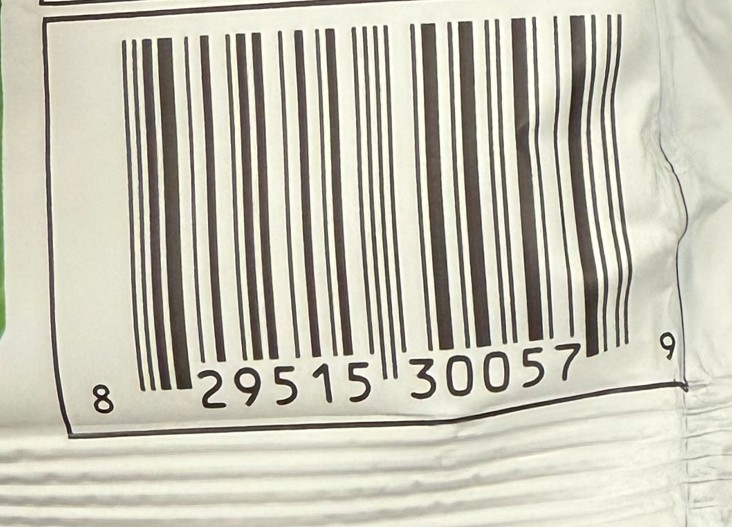

In [25]:
img_path = Path("barcode.jpg")
if img_path.exists():
    # Preview the image (fast, no Pillow needed)
    from IPython.display import display, Image as IPImage
    display(IPImage(filename=str(img_path)))  # shows the picture inline
else:
    print("[Info] Sample image not found; skipping image demo.")

Now let's see if our agent can extract the barcode and pass it to its barcode reader tool.

In [26]:
@trace_function("orchestrator.phase1.image")
async def test_phase1_image(image_path: Path):
    if not image_path.exists():
        logfire.error(f"Image not found: {image_path}")
        return "[Error] Image file not found"
    
    mime = mimetypes.guess_type(str(image_path))[0] or "image/jpeg"
    content = [
        "Use the image: extract a barcode (remove all spaces and extra chars); and call off_by_barcode or off_search_by_name to list ingredients.",
        BinaryContent(data=image_path.read_bytes(), media_type=mime),
    ]
    
    async with orchestrator_phase1_off:
        with logfire.span("orchestrator.phase1_off.image", image=str(image_path)):
            result = await orchestrator_phase1_off.run(content)
            logfire.info("Phase1 image processing completed", extra={
                "image": str(image_path),
                "mime_type": mime,
                "file_size": image_path.stat().st_size,
                "response_length": len(result.output) if result.output else 0,
                "result": result
            })
            return result.output

In [27]:
with logfire.span("test.phase1_image"):
    image_result = await test_phase1_image(img_path)
    print(image_result)

18:29:11.243 test.phase1_image
             │ /tmp/ipykernel_375176/4083283086.py:1
18:29:11.244   orchestrator.phase1.image
             │ /tmp/ipykernel_375176/560691417.py:20
18:29:11.962     orchestrator.phase1_off.image
             │ /tmp/ipykernel_375176/2268281843.py:14
             │ image='barcode.jpg'
18:29:12.397       off_api.by_barcode
             │ /tmp/ipykernel_375176/560691417.py:7
18:29:12.399         off.barcode_lookup
             │ /tmp/ipykernel_375176/4082331844.py:7
             │ barcode='829515300579'
18:29:12.909           OFF barcode lookup
             │ /tmp/ipykernel_375176/4082331844.py:9 info
             │ extra={
             │           'barcode': '829515300579',
             │           'found': True,
             │           'product_name': 'Garden Veggie Straws Sea Salt',
             │       }
18:29:13.928       Phase1 image processing completed
             │ /tmp/ipykernel_375176/2268281843.py:16 info
             │ extra={
             │    

# 11) Wrap Consultant as a Tool

Expose the Consultant as a callable tool (e.g., `consult_nutritionist(...)`.

**Goals**
- Accept **product name** or **ingredient list** and an optional **goal** (e.g., `low_sodium`).
- Call the **Consultant agent** internally and **parse JSON** safely.
- Return a minimal **fallback** JSON if the consultant returns malformed data.


In [28]:
@trace_function("consultant.tool.consult_nutritionist")
async def consult_nutritionist_fn(
    ingredients: List[str],
    sodium_mg_per_serving: Optional[int] = None,
    product_name: Optional[str] = None,
) -> dict:
    print("consultant agent is called")
    
    with logfire.span("consultant.prepare_payload"):
        payload = {"product_name": product_name, "ingredients": ingredients}
        logfire.info("Consultant payload prepared", extra={
            "product_name": product_name,
            "ingredients": ingredients,
            "sodium_mg": sodium_mg_per_serving
        })
    
    async with consultant_agent:
        with logfire.span("consultant.agent.evaluate"):
            start_time = time.time()
            res = await consultant_agent.run(json.dumps(payload))
            duration = time.time() - start_time
            
            logfire.info("Consultant evaluation complete", extra={
                "duration_seconds": duration,
                "response_length": len(res.output) if res.output else 0,
                "result": res
            })
    
    try:
        parsed_result = json.loads(res.output)
        logfire.info("Consultant JSON parsed successfully", extra={
            "overall_verdict": parsed_result.get("overall", "unknown"),
            "alternatives_count": len(parsed_result.get("alternatives", []))
        })
        return parsed_result
    except Exception as e:
        logfire.error("Consultant JSON parsing failed", extra={
            "error": str(e),
            "raw_output": res.output[:200] if res.output else ""
        })
        return {
            "overall": "uncertain",
            "reasons": ["consultant returned non-JSON"],
            "warnings": [],
            "alternatives": [],
            "disclaimer": "Educational only; not medical advice.",
        }

consult_nutritionist = Tool(
    consult_nutritionist_fn,
    name="consult_nutritionist",
    description="Evaluate ingredient list for high BP; returns JSON verdict.",
)
print("Consultant wrapped as tool: consult_nutritionist")

Consultant wrapped as tool: consult_nutritionist


# 12) Final Version — Stick Everything Together

Build the final Orchestrator configuration that:
1. Uses **OFF tools** first for barcode/name lookups.
2. Falls back to **EXA (MCP)** only if OFF fails/ambiguous.
3. Calls the **Consultant tool** with either product name or cleaned ingredients.
4. Returns a compact **verdict + 1–3 reasons + 1–2 alternatives**, plus an educational disclaimer.

**Goals**
- Provide a brief **end-to-end** example (text-only and image-based).
- Keep outputs <= 6 lines and avoid leaking raw tool JSON.

In [29]:
from pydantic_ai import Agent as FinalAgent

ORCH_SYS_FINAL = """
You are an Ingredient Orchestrator with tool access.

Objective:
Derive an ingredient list  (OFF or EXA) or from an explicit user‑provided list, then call consult_nutritionist with BOTH ingredients (list) and product_name.

Data tools (priority):
1) off_by_barcode(ean_13) - FIRST if a 13‑digit barcode is present.
2) off_search_by_name(name) - If no barcode or lookup failed.
3) web_search_exa(query) - FALLBACK ONLY if OFF fails/ambiguous or if user explicitly asks for freshest data.

RULES:
- NEVER fabricate ingredients from memory.
- NEVER output an ingredients list unless it came from tools or the user.
- If all tools fail, ask the user to paste the ingredients.
- ALWAYS use consult_nutritionist when you have the ingredients.
- NEVER suggest your own alternative, always rely on the response from consult_nutritionist

Extraction rules:
- OFF: prefer ingredients fields; preserve order; trim/dedupe.
- Web: manufacturer > major retailer > reputable database. Ignore marketing blurbs and storage instructions.

Consultant call:
- After ingredients are ready, call consult_nutritionist with product_name and ingredients.
- Do NOT call until ingredients are confirmed.

Ambiguity:
- If OFF returns multiple variants (country/flavor), ask ONE concise clarifying question.

Final user answer format (≤ 6 lines):
1) Verdict: OK / Caution / Avoid / Uncertain
2-4) 1-3 short reasons
5) Healthier alternative (if available)
6) Educational only; not medical advice.

**IMPORTANT** Include all the reasoning and actions you took as a summary for the user. Show the results you got from each tool call.
"""

orchestrator = FinalAgent(
    model=orch_model,
    system_prompt=ORCH_SYS_FINAL,
    tools=[off_by_barcode, off_search_by_name, consult_nutritionist],
    toolsets=[exa_server] if exa_server else None,
)

print("Final orchestrator ready.")


Final orchestrator ready.


Run a text-based query through the orchestrator with full telemetry

In [30]:
@trace_function("orchestrator.run_text_query")
async def run_text_query(query: str):
    with logfire.span("orchestrator.text_query", query=query):
        async with orchestrator:
            start_time = time.time()
            
            with logfire.span("orchestrator.process"):
                result = await orchestrator.run(query)
                
            duration = time.time() - start_time
            
            logfire.info("Query completed", extra={
                "query": query,
                "duration_seconds": duration,
                "response_length": len(result.output) if result.output else 0,
                "result": result
            })
            
            return result.output

In [31]:
with logfire.span("test.orchestrator_final"):
            text_result = await run_text_query("Is Kitkat USA safe to eat for High Blood Pressure?")
            print(text_result)

18:47:39.528 test.orchestrator_final
             │ /tmp/ipykernel_375176/1320562359.py:1
18:47:39.528   orchestrator.run_text_query
             │ /tmp/ipykernel_375176/560691417.py:20
18:47:39.529     orchestrator.text_query
             │ /tmp/ipykernel_375176/3653966197.py:3
             │ query='Is Kitkat USA safe to eat for High Blood Pressure?'
18:47:40.318       orchestrator.process
             │ /tmp/ipykernel_375176/3653966197.py:7
18:47:41.051         off_api.by_barcode
             │ /tmp/ipykernel_375176/560691417.py:7
18:47:41.051           off.barcode_lookup
             │ /tmp/ipykernel_375176/4082331844.py:7
             │ barcode='078742001122'
18:47:41.445           OFF barcode lookup failed
             │ /tmp/ipykernel_375176/4082331844.py:16 error
             │ extra={
             │           'barcode': '078742001122',
             │           'error': "Client error '404 Not Found' for url 'https://world.openfoodfacts.org/api/v2/product/078742001122.json'\nFor 

Run an image-based query through the orchestrator with full telemetry

In [32]:
@trace_function("orchestrator.run_image_query")
async def run_image_query(image_path: Path, instruction: str):
    with logfire.span("orchestrator.image_query", image=str(image_path), instruction=instruction):
        if not image_path.exists():
            logfire.error(f"Image not found: {image_path}")
            return "[Error] Image file not found"
        
        mime = mimetypes.guess_type(str(image_path))[0] or "image/jpeg"
        
        with logfire.span("orchestrator.prepare_image"):
            content = [
                instruction,
                BinaryContent(data=image_path.read_bytes(), media_type=mime),
            ]
            logfire.info("Image prepared", extra={
                "mime_type": mime,
                "file_size": image_path.stat().st_size
            })
        
        async with orchestrator:
            start_time = time.time()
            
            with logfire.span("orchestrator.process_image"):
                result = await orchestrator.run(content)
            
            duration = time.time() - start_time
            
            logfire.info("Image query completed", extra={
                "image": str(image_path),
                "duration_seconds": duration,
                "response_length": len(result.output) if result.output else 0,
                "result": result
            })
            
            return result.output

In [33]:
with logfire.span("test.orchestrator_final_image"):
    final_image_result = await run_image_query(
        img_path,
        "Analyze this product for someone with high blood pressure"
    )
    print(final_image_result)

18:47:58.128 test.orchestrator_final_image
             │ /tmp/ipykernel_375176/1147491093.py:1
18:47:58.128   orchestrator.run_image_query
             │ /tmp/ipykernel_375176/560691417.py:20
18:47:58.130     orchestrator.image_query
             │ /tmp/ipykernel_375176/124263575.py:3
             │ image='barcode.jpg'
             │ instruction='Analyze this product for someone with high blood pressure'
18:47:58.130       orchestrator.prepare_image
             │ /tmp/ipykernel_375176/124263575.py:10
18:47:58.131         Image prepared
             │ /tmp/ipykernel_375176/124263575.py:15 info
             │ extra={
             │           'mime_type': 'image/jpeg',
             │           'file_size': 98105,
             │       }
18:47:58.988       orchestrator.process_image
             │ /tmp/ipykernel_375176/124263575.py:23
18:47:59.697         off_api.by_barcode
             │ /tmp/ipykernel_375176/560691417.py:7
18:47:59.698           off.barcode_lookup
             │ /tmp/ip